# Explore usage of Sentiwordnet and potential drawbacks
Based on the data available [here](https://www.kaggle.com/marklvl/sentiment-labelled-sentences-data-set)

In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn

In [3]:
from IPython.display import display

In [7]:
with open('../data/imdb_labelled.txt', 'r') as infile:
    lines = infile.readlines()

In [8]:
data = [(x[0].rstrip(), int(x[1].rstrip())) for x in [k.split('\t') for k in lines]]

In [9]:
data[0]

('A very, very, very slow-moving, aimless movie about a distressed, drifting young man.',
 0)

In [10]:
print(set([y for x, y in data]))

{0, 1}


## Tokenize

In [12]:
import spacy

In [13]:
nlp = spacy.load("en_core_web_lg")

In [29]:
tokens = lambda x: [(w.text, w.pos_) for w in nlp(x) if w.pos_ not in [
    'PUNCT', 'DET']]

In [30]:
tokens(data[0][0])[:6]

[('very', 'ADV'),
 ('very', 'ADV'),
 ('very', 'ADV'),
 ('slow', 'ADV'),
 ('moving', 'VERB'),
 ('aimless', 'ADJ')]

## SentiWordnet

In [31]:
pos_map = {'NOUN': wn.NOUN, 'ADV': wn.ADV, 'ADJ': wn.ADJ, 'VERB': wn.VERB}

In [32]:
def get_pos(pos_token):
    try:
        return pos_map[pos_token]
    except KeyError:
        return None

In [33]:
def scores(token, pos):
    synsets = wn.synsets(token, pos=get_pos(pos))
    if len(synsets) == 0:
        return np.zeros(1), np.zeros(1), np.zeros(1)
    else:
        plus, minus, obj = np.zeros(len(synsets)), np.zeros(len(synsets)), np.zeros(len(synsets))
        for i, syn in enumerate(synsets):
            sw = swn.senti_synset(syn.name())
            plus[i] = sw.pos_score()
            minus[i] = sw.neg_score()
            obj[i] = sw.obj_score()
        return plus, minus, obj

In [34]:
def mean_strategy(text):
    tks = tokens(text)
    m = np.zeros((len(tks), 3))
    for i, (token, p) in enumerate(tks):
        p, n, o = scores(token, p)
        m[i] = np.array([p.mean(), n.mean(), o.mean()])
    return m

In [35]:
display(mean_strategy(data[0][0]))
display(mean_strategy(data[0][0]).mean(axis=0))

array([[0.25      , 0.125     , 0.625     ],
       [0.25      , 0.125     , 0.625     ],
       [0.25      , 0.125     , 0.625     ],
       [0.        , 0.        , 1.        ],
       [0.046875  , 0.0234375 , 0.9296875 ],
       [0.1875    , 0.        , 0.8125    ],
       [0.        , 0.        , 1.        ],
       [0.0625    , 0.03125   , 0.90625   ],
       [0.0625    , 0.78125   , 0.15625   ],
       [0.025     , 0.0625    , 0.9125    ],
       [0.15      , 0.15      , 0.7       ],
       [0.01136364, 0.        , 0.98863636]])

array([0.10797822, 0.11861979, 0.77340199])

## Explore the dataset

In [36]:
sentence_scores = np.array([mean_strategy(x).mean(axis=0) for x, _ in data])

In [37]:
sentence_scores

array([[0.10797822, 0.11861979, 0.77340199],
       [0.04490501, 0.09180223, 0.73829276],
       [0.05327299, 0.06953248, 0.59148025],
       ...,
       [0.00576923, 0.15384615, 0.84038462],
       [0.00892857, 0.33035714, 0.66071429],
       [0.06388889, 0.04401709, 0.58440171]])

In [38]:
import matplotlib.pyplot as plt

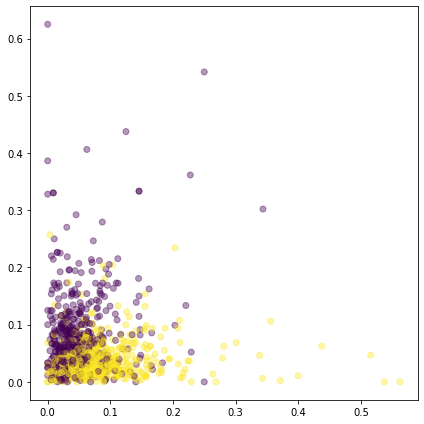

In [39]:
fig, ax = plt.subplots(figsize=(6, 6))
colors = [y for _, y in data]
ax.scatter(sentence_scores[:,0], sentence_scores[:,1], alpha=0.4, c=colors)
plt.tight_layout()
plt.show()

## Check errors and performances
- **Exercise**: try with a non-trivial supervised classifier
- **Exercise**: try with another non-trivial unsupervised classifier

In [41]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [43]:
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier()

In [44]:
def dummy_classifier(X):
    return np.array([x[0] > x[1] for x in X]).astype(int)

In [45]:
y = np.array([j for _, j in data])
X_train, X_test, y_train, y_test = train_test_split(sentence_scores, y, test_size=0.33, random_state=42)

In [46]:
knn.fit(X_train, y_train)
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [47]:
y_pred = dummy_classifier(X_test)
y_pred_knn = knn.predict(X_test)
y_pred_dt = dt.predict(X_test)

In [48]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.62      0.68       155
           1       0.71      0.82      0.76       175

    accuracy                           0.73       330
   macro avg       0.73      0.72      0.72       330
weighted avg       0.73      0.73      0.72       330



In [49]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.62      0.63      0.63       155
           1       0.67      0.66      0.67       175

    accuracy                           0.65       330
   macro avg       0.65      0.65      0.65       330
weighted avg       0.65      0.65      0.65       330



In [50]:
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.62      0.66      0.64       155
           1       0.68      0.64      0.66       175

    accuracy                           0.65       330
   macro avg       0.65      0.65      0.65       330
weighted avg       0.65      0.65      0.65       330



In [51]:
cm = confusion_matrix(y_test, y_pred_knn, labels=[0, 1])
cmd = ConfusionMatrixDisplay(cm)

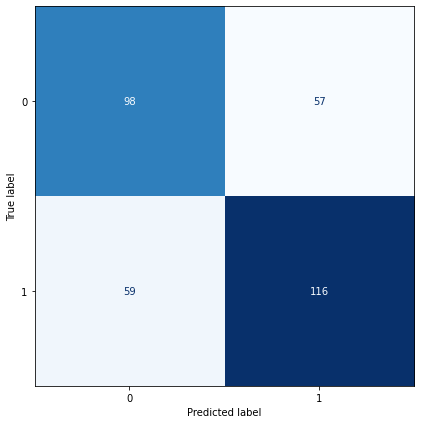

In [52]:
fig, ax = plt.subplots(figsize=(6, 6))
cmd.plot(ax=ax, cmap='Blues', colorbar=False)
plt.tight_layout()
plt.show()

### False positive vs False negative

In [53]:
all_sentences = dummy_classifier(sentence_scores)

In [54]:
fp = [i for i, v in enumerate(all_sentences) if v == 1 and y[i] == 0]
fn = [i for i, v in enumerate(all_sentences) if v == 0 and y[i] == 1]

In [55]:
print(len(fp), len(fn))

177 100


In [56]:
for s in fp[:10]:
    print(data[s][0])
    print(sentence_scores[s], '\n')

Very little music or anything to speak of.
[0.05703125 0.04492188 0.52304688] 

The rest of the movie lacks art, charm, meaning... If it's about emptiness, it works I guess because it's empty.
[0.05408399 0.01989914 0.67601687] 

Graphics is far from the best part of the game.
[0.08837603 0.00876501 0.65285896] 

Today the graphics are crap.
[0.02232143 0.00446429 0.72321429] 

This was a flick doomed from its conception.
[0.02008929 0.00297619 0.81026786] 

The very idea of it was lame - take a minor character from a mediocre PG-13 film, and make a complete non-sequel while changing its tone to a PG-rated family movie.
[0.06935765 0.06400099 0.58092707] 

I wasn't the least bit interested.
[0.05654762 0.0275974  0.74918831] 

But even the talented Carrell can't save this.
[0.09577922 0.02922078 0.73214286] 

The story itself is just predictable and lazy.
[0.01900183 0.01167582 0.68360806] 

But whatever it was that cost them so much, it didn't translate to quality, that's for sure.
[0

In [31]:
for s in fn[:10]:
    print(data[s][0])
    print(sentence_scores[s], '\n')

This review is long overdue, since I consider A Tale of Two Sisters to be the single greatest film ever made.
[0.04104811 0.04390426 0.74838096] 

I'll put this gem up against any movie in terms of screenplay, cinematography, acting, post-production, editing, directing, or any other aspect of film-making.
[0.01602914 0.01739211 0.75824541] 

In other words, the content level of this film is enough to easily fill a dozen other films.
[0.04646011 0.05169872 0.76850783] 

It is an insane game.
[0.05976836 0.10992133 0.83031031] 

Waste your money on this game.
[0.03380682 0.03636364 0.92982955] 

As they say in Canada, This is the fun game, aye.
[0.0083819  0.01135392 0.64693085] 

This game rocks.
[0.01136364 0.02272727 0.96590909] 

The film succeeds despite, or perhaps because of, an obviously meagre budget.
[0.05625 0.10625 0.6375 ] 

It's hard not to fall head-over-heels in love with that girl.
[0.02817027 0.08306927 0.65799123] 

Sam Shepard's portrayal of a gung ho Marine was sober